## Chain Line extraction for reflected light images
### 0. Load relevant packages

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d, rotate

### 1. Pre-processing 
Pixel size measurements can be done using Canny edge detection. As this part is dependent on details from the reflected light image, it isn't included in this code
### 2. Patch selection
Again dependent on the image and needs to be done by the user independently.
### 3. Spectral TV decomposition
Code is available by e.g. Gilboa et al. (https://guygilboa.net.technion.ac.il/2020/10/09/spectral-total-variation-color/) in Matlab. Run the matlab code first and load the results here next. In case of obtaining the TV flow solution instead of the spectral TV decomposition directly, we have included code to derive the decomposition based on the TV flow solution. This may be more flexible when deciding how to filter the decomposition.
#### 3.1 Load Data


In [2]:
u = sio.loadmat('INSERT_FILE_NAME.mat')
u = u['u'] # This is assuming TV flow data, for spectral TV decomposition data based on the Gilboa et al. code write: u_0 = u_0['f_H'] to load filtered images.
u = np.moveaxis(u, -1, 0)

#### 3.2 a) Derive spectral TV decomposition from TV Flow data
This is in case TV flow results are loaded instead of the spectral decomposition results. Uncomment the following cell if spectral TV decomposed data was loaded directly.

In [3]:
# def spectral_TV_decomp(u,num_bands):
#     u0 = u[0,:,:]
#     u1 = u[1,:,:]
#     u2 = u[2,:,:]
#     Phi = []
#     dt = 1/75 # based on the discretisation in the TV flow solution
#     for i in range(num_bands): 
#         ddu = (u0+u2-2*u1)/(dt**2)
#         t = (i+1)*dt
#         phi = ddu*t
#         Phi.append(phi)
#         u0 = u1
#         u1 = u2
#         u2 = u[i+3,:,:]
#     f_r = (num_bands+1)*u1 - num_bands*u2 
#     return Phi, f_r

# num_bands=29 # in relation to the TV flow discretisation dt.
# Phi, f_r = spectral_TV_decomp(u,num_bands)
# phi = np.array(Phi)
# dec_phi = np.sum(phi[1:],axis=0) # Excluding the first element to surpress small noise

#### 3.2 b) For directly loaded spectral TV decomposition data
Comment the following cell if spectral TV decomposition data was loaded directly and not TV flow data.

In [7]:
dec_phi = u

### 4. Fourier Filtering
Enhance chain lines in the frequency domain. First, we define functions for filtering and plotting the filtered images. The rectangularFilter function has the option for vertial and horizontal filtering. The filter_dir should be perpendicular to the chain line direction and depends on the orientation of the image.

In [4]:
# Define rectangular filter for Fourier filtering 
class rectangleFilter:
    def __init__(self, filter_dir, imgShape):
        super().__init__()
        self.filter_dir = filter_dir
        self.imgShape = imgShape
    
    def __call__(self,length,width):
        #filter_dir is based on the orientation of the image. The filter_dir should be perpendicular to the chain line direction
        if self.filter_dir == 'vertical': 
            base = np.zeros(self.imgShape[:2])
            rows, cols = self.imgShape[:2]
            base[length:rows-length,int(cols/2)-width:int(cols/2)+width] = 1
        elif self.filter_dir == 'horizontal':
            base = np.zeros(self.imgShape[:2])
            rows, cols = self.imgShape[:2]
            base[int(rows/2)-width:int(rows/2)+width,length:cols-length] = 1
        else:
            print('Error, please select either vertical or horizontal')
        return base
    
# Define plotting class
class plot_FFT:
    def __init__(self,Filter,save='False'):
        super().__init__()
        self.Filter = Filter
        self.save = save
        
    def __call__(self,img,width,length):
        original = np.fft.fft2(img)
        center = np.fft.fftshift(original)
        magnitude_spec = np.log(1+np.abs(center))
        
        fig, axes = plt.subplots(2, 3, figsize=(25,6), constrained_layout=False)
        ax_row = axes[0]
        ax_row[0].imshow(img, "gray")
        ax_row[0].set_title(f'Spectral TV Image ({num_bands} bands)')
        ax_row[0].axis('off')

        ax_row[1].imshow(magnitude_spec, "gray")
        ax_row[1].set_title("Centered Spectrum")
        ax_row[1].axis('off')

        LowPassCenter = center * self.Filter(length,width)
        ax_row[2].imshow(np.log(1+np.abs(LowPassCenter)), "gray")
        ax_row[2].set_title("Centered Spectrum multiply Low Pass Filter")
        ax_row[2].axis('off')

        ax_row = axes[1]
        LowPass = np.fft.ifftshift(LowPassCenter)
        inverse_LowPass = np.fft.ifft2(LowPass)
        ax_row[0].imshow(np.abs(inverse_LowPass), "gray")
        ax_row[0].set_title(f"Processed Image with length {length} and width {width}")
        ax_row[0].axis('off')

        LowPassCenter = np.fft.ifftshift(center * self.Filter(length,width-1))
        inverse_LowPass = np.fft.ifft2(LowPassCenter)
        ax_row[1].imshow(np.abs(inverse_LowPass), "gray")
        ax_row[1].set_title(f"Processed Image with length {length} and width {width-1}")
        ax_row[1].axis('off')

        LowPassCenter = np.fft.ifftshift(center * self.Filter(length,width-2))
        inverse_LowPass = np.fft.ifft2(LowPassCenter)
        ax_row[2].imshow(np.abs(inverse_LowPass), "gray")
        ax_row[2].set_title(f"Processed Image with length {length} and width {width-2}")
        ax_row[2].axis('off')
        
        if self.save == 'True':
            plt.savefig('FILE_NAME.png')

        plt.show()

Next, we initialise the filter and plotting functions for the decomposed image. In some cases it may be necessary to rotate the image as well for ease of analysis. We choose length and width for the filtering based on the image size. The plotter will render results for width, width-1 and width-2.

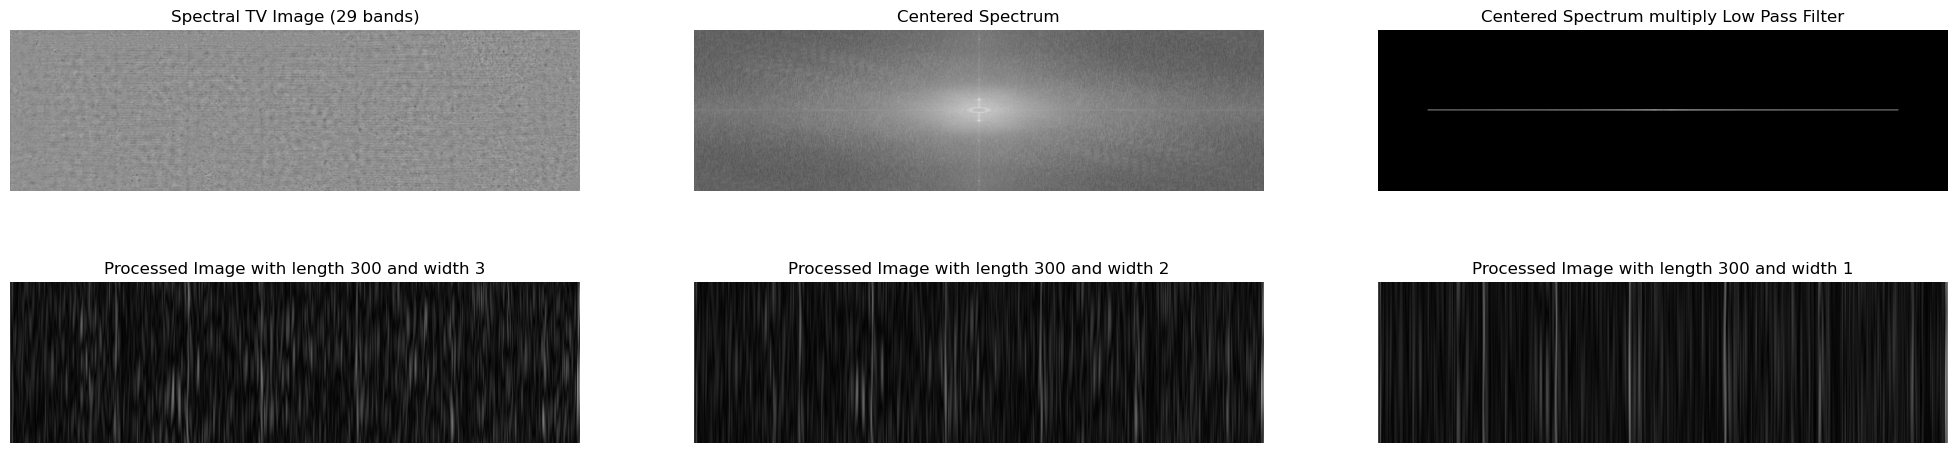

In [5]:
img = dec_phi #rotate(dec_phi,90) #in some cases, rotation may be necessary
Filter = rectangleFilter(filter_dir = 'horizontal',imgShape = img.shape)
plotter = plot_FFT(Filter,save='False') # initialise plotter

length = 300
width = 3
plotter(img,width,length)

Based on the filtering results, we choose the width that render the best filtered results to use in the rest of the analysis

In [6]:
original = np.fft.fft2(img) 
center = np.fft.fftshift(original)
LowPassCenter = np.fft.ifftshift(center * Filter(length,width-2)) 
inverse_LowPass = np.fft.ifft2(LowPassCenter)

### 5. Projection
Project the filtered image onto the relevant axis.

In [7]:
y = np.sum(np.abs(inverse_LowPass),axis=0)# change to axis=1 for vertical filter
x = np.linspace(0,y.shape[0],y.shape[0])

### 6. Peak detection
Locate peaks with highest magnitude, representing the chain lines. The variable "height" represents the cut-off threshold and is to be chosen manually. We include gaussian smoothing of the 1D signal to filter out noise.

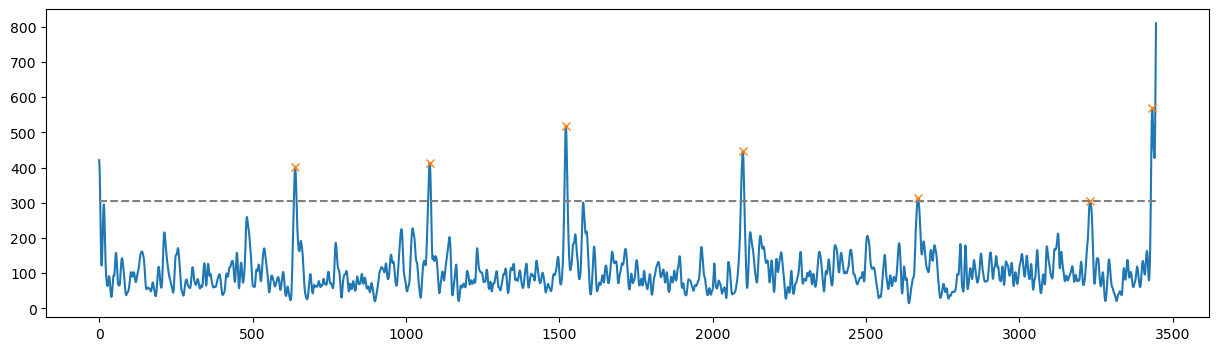

In [8]:
height=305
fil=1
sigma = 2 # standard deviation of the gaussian kernel for filtering
if fil ==1:
    y_ = gaussian_filter1d(y,sigma) # smoothing of the signal
else:
    y_ = y
    
peaks_y, _ = find_peaks(y_, height=height)

# Plot the detected peaks in the signal
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(x,y_)
ax.plot(x[peaks_y],y_[peaks_y], "x")
ax.plot(x,height*np.ones_like(x), "--", color="gray")
plt.show()

### 7. Chain line distance measuring and plotting

In [9]:
cm_px = 0.0647 # factor of millimetre per pixel to convert pixel distance into millimetre distances
distances = (peaks_y[1:]-peaks_y[:-1])*cm_px
print('The chainline distances in centimetre are: ', distances, ' with a mean distance of ', np.mean(distances),'mm.')

The chainline distances in centimetre are:  [28.3386 28.7268 37.3319 36.9437 36.2967 13.1341]  with a mean distance of  30.12863333333333 mm.


(-0.5, 3445.5, 974.5, -0.5)

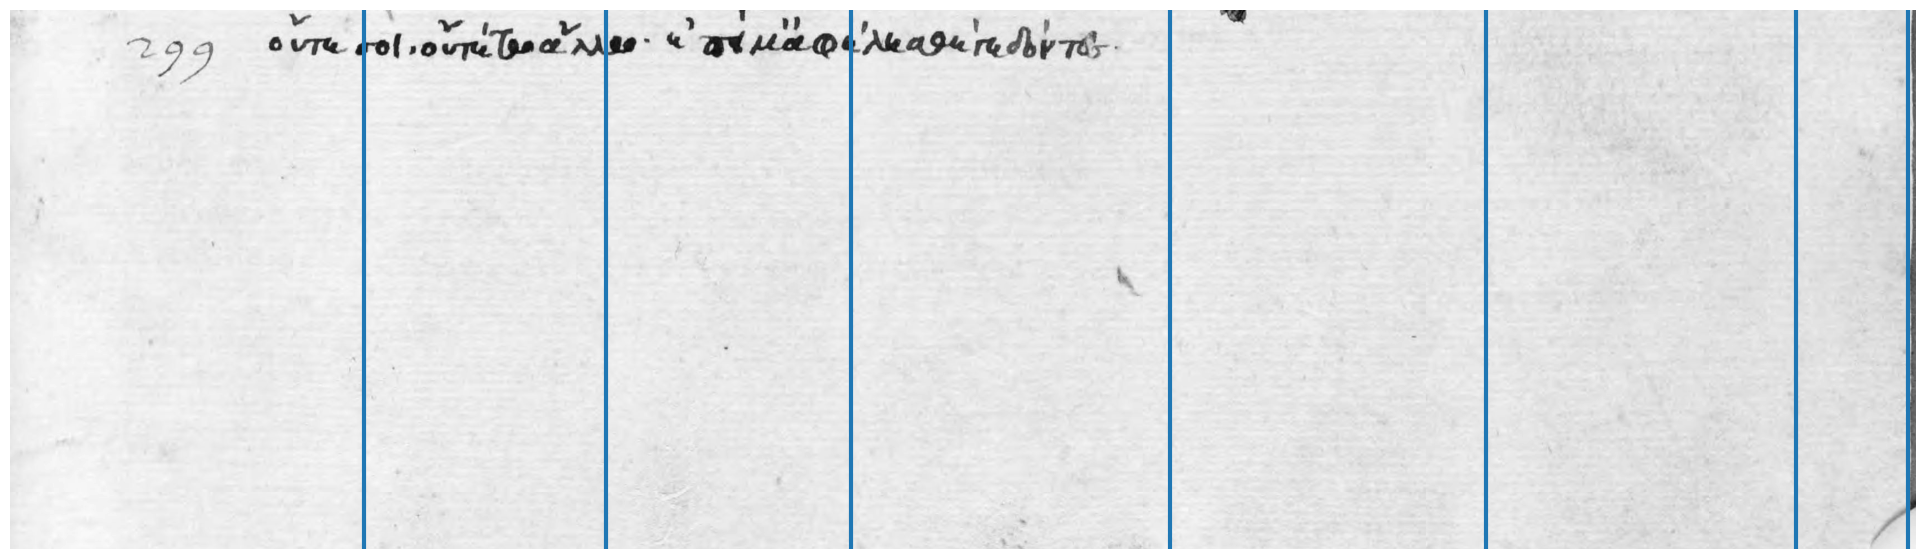

In [11]:
plt.figure(figsize=(25,7), constrained_layout=False)
# img = rotate(u_0[0,:,:], 90., reshape=True) # for images with vertical filter
plt.imshow(u[0,:,:], cmap='gray') # display the original image
thet = 0.
for peak in range(0,len(peaks_y)): # draw detected chain lines
    (x0, y0) = peaks_y[peak] * np.array([np.cos(np.deg2rad(thet)), np.sin(np.deg2rad(thet))])
    plt.axline((x0, y0), slope=-np.tan(np.deg2rad(thet)+ np.pi/2),linewidth=3)
plt.axis('off')